In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.linalg import cholesky, solve_triangular, eigh

In [14]:
def generate_data(n_samples=400, centers=4, cluster_std=0.8, random_state=0):
    X, y = make_blobs(n_samples=n_samples, centers=centers, cluster_std=cluster_std, random_state=random_state)
    return X, y

In [15]:
def log_multivariate_normal_density(X, means, covs, cov_type, var_floor=1e-6):
    n, d = X.shape
    k = means.shape[0]
    log_prob = np.empty((n, k))
    for j in range(k):
        mu = means[j]
        if cov_type == 'spherical':
            var = max(covs[j], var_floor)
            const = -0.5 * d * np.log(2 * np.pi * var)
            diff = X - mu
            maha = -0.5 * np.sum(diff**2, axis=1) / var
            log_prob[:, j] = const + maha
        elif cov_type == 'diag':
            var = np.maximum(covs[j], var_floor)
            const = -0.5 * (d * np.log(2 * np.pi) + np.sum(np.log(var)))
            diff = X - mu
            maha = -0.5 * np.sum((diff**2) / var, axis=1)
            log_prob[:, j] = const + maha
        else:  # full
            cov = covs[j].copy()
            cov.flat[::d+1] += var_floor
            L = cholesky(cov, lower=True)
            log_det = 2.0 * np.sum(np.log(np.diag(L)))
            diff = X - mu
            sol = solve_triangular(L, diff.T, lower=True)
            maha = -0.5 * np.sum(sol**2, axis=0)
            const = -0.5 * (d * np.log(2 * np.pi) + log_det)
            log_prob[:, j] = const + maha
    return log_prob

def initialize_params(X, k, cov_type='full', init_method='kmeans', random_state=None):
    n, d = X.shape
    rng = np.random.RandomState(random_state)
    if init_method == 'kmeans':
        km = KMeans(n_clusters=k, n_init=3, random_state=random_state).fit(X)
        labels = km.labels_
        means = km.cluster_centers_
    else:
        choices = rng.choice(n, k, replace=False)
        means = X[choices]
        labels = None

    weights = np.ones(k) / k
    if cov_type == 'spherical':
        covs = np.zeros(k)
        overall_var = np.var(X)
        for j in range(k):
            if labels is None:
                covs[j] = overall_var
            else:
                pts = X[labels == j]
                covs[j] = np.var(pts) if pts.shape[0] > 1 else overall_var * 0.1
    elif cov_type == 'diag':
        covs = np.zeros((k, d))
        overall_var = np.var(X, axis=0) + 1e-6
        for j in range(k):
            if labels is None:
                covs[j] = overall_var
            else:
                pts = X[labels == j]
                covs[j] = np.var(pts, axis=0) if pts.shape[0] > 1 else overall_var * 0.1
    else:
        covs = np.zeros((k, d, d))
        overall_cov = np.cov(X.T) + np.eye(d)*1e-6
        for j in range(k):
            if labels is None:
                covs[j] = overall_cov
            else:
                pts = X[labels == j]
                covs[j] = np.cov(pts.T) + np.eye(d)*1e-6 if pts.shape[0] > 1 else overall_cov * 0.1
    return weights, means, covs


In [16]:
def e_step(X, weights, means, covs, cov_type, var_floor=1e-6):
    log_prob = log_multivariate_normal_density(X, means, covs, cov_type, var_floor=var_floor)
    log_prob += np.log(weights + 1e-12)
    amax = np.max(log_prob, axis=1, keepdims=True)
    exp_lp = np.exp(log_prob - amax)
    resp = exp_lp / np.sum(exp_lp, axis=1, keepdims=True)
    log_likelihood = np.sum(amax.flatten() + np.log(np.sum(exp_lp, axis=1)))
    return resp, log_likelihood


In [17]:
def m_step(X, resp, cov_type='full', var_floor=1e-6):
    n, d = X.shape
    k = resp.shape[1]
    nk = resp.sum(axis=0) + 1e-12
    weights = nk / n
    means = (resp.T @ X) / nk[:, None]
    if cov_type == 'spherical':
        covs = np.zeros(k)
        for j in range(k):
            diff = X - means[j]
            val = (resp[:, j][:, None] * (diff**2)).sum() / (nk[j] * d)
            covs[j] = max(val, var_floor)
    elif cov_type == 'diag':
        covs = np.zeros((k, d))
        for j in range(k):
            diff = X - means[j]
            val = (resp[:, j][:, None] * (diff**2)).sum(axis=0) / nk[j]
            covs[j] = np.maximum(val, var_floor)
    else:  # full
        covs = np.zeros((k, d, d))
        for j in range(k):
            diff = X - means[j]
            weighted = diff.T * resp[:, j]
            cov = (weighted @ diff) / nk[j]
            cov.flat[::d+1] += var_floor
            covs[j] = cov
    return weights, means, covs


In [18]:
def fit_gmm_em(X, k, cov_type='full', max_iter=100, tol=1e-4, var_floor=1e-6, init_method='kmeans', random_state=None, verbose=False):
    weights, means, covs = initialize_params(X, k, cov_type=cov_type, init_method=init_method, random_state=random_state)
    log_likelihoods = []
    for i in range(max_iter):
        resp, log_likelihood = e_step(X, weights, means, covs, cov_type, var_floor=var_floor)
        weights, means, covs = m_step(X, resp, cov_type=cov_type, var_floor=var_floor)
        log_likelihoods.append(log_likelihood)
        if verbose and i % 10 == 0:
            print(f"iter {i}: ll = {log_likelihood:.6f}")
        if i > 0 and abs(log_likelihoods[-1] - log_likelihoods[-2]) < tol:
            break
    return {
        'weights': weights,
        'means': means,
        'covs': covs,
        'resp': resp,
        'log_likelihoods': np.array(log_likelihoods),
        'n_iter': len(log_likelihoods),
        'final_ll': log_likelihoods[-1]
    }


In [19]:
def run_multiple_inits(X, k, cov_type='full', n_init=3, init_method='kmeans', **kwargs):
    best_model = None
    for seed in range(n_init):
        model = fit_gmm_em(X, k, cov_type=cov_type, init_method=init_method, random_state=seed, **kwargs)
        if best_model is None or model['final_ll'] > best_model['final_ll']:
            best_model = model
    return best_model

In [20]:
def bic_aic(X, model):
    n, d = X.shape
    k = model['means'].shape[0]
    covs = model['covs']
    if covs.ndim == 1:  # spherical
        cov_params = k * 1
    elif covs.ndim == 2:  # diag
        cov_params = covs.size
    else:
        cov_params = k * d * (d + 1) / 2
    p = (k - 1) + k * d + cov_params
    ll = model['final_ll']
    bic = -2 * ll + p * np.log(n)
    aic = -2 * ll + 2 * p
    return bic, aic, p

In [21]:
def plot_loglikelihood(models, labels=None, title="Log-likelihood vs iteration"):
    plt.figure(figsize=(6,4))
    for i, m in enumerate(models):
        lbl = labels[i] if labels is not None else None
        plt.plot(m['log_likelihoods'], label=lbl)
    if labels:
        plt.legend()
    plt.xlabel("Iteration")
    plt.ylabel("Log-likelihood")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_gmm_ellipses(X, model, cov_type='full', ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,6))
    means = model['means']
    covs = model['covs']
    k = means.shape[0]
    ax.scatter(X[:,0], X[:,1], s=10)
    for j in range(k):
        mu = means[j]
        if cov_type == 'spherical':
            var = covs[j]
            width = 2 * np.sqrt(var)
            height = 2 * np.sqrt(var)
            angle = 0
        elif cov_type == 'diag':
            eigvals = covs[j]
            width = 2 * np.sqrt(eigvals[0])
            height = 2 * np.sqrt(eigvals[1])
            angle = 0
        else:
            cov = covs[j]
            eigvals, eigvecs = eigh(cov)
            order = eigvals.argsort()[::-1]
            eigvals = eigvals[order]
            eigvecs = eigvecs[:, order]
            angle = np.degrees(np.arctan2(eigvecs[1,0], eigvecs[0,0]))
            width = 2 * np.sqrt(eigvals[0])
            height = 2 * np.sqrt(eigvals[1])
        e = Ellipse(xy=mu, width=width*2, height=height*2, angle=angle, alpha=0.25)
        ax.add_patch(e)
        ax.text(mu[0], mu[1], str(j), fontsize=12, fontweight='bold')
    ax.set_title(f"GMM components ({cov_type})")
    plt.show()


c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

spherical -> final LL = -1843.63, iters = 22
diag -> final LL = -1841.86, iters = 13
full -> final LL = -1841.00, iters = 13


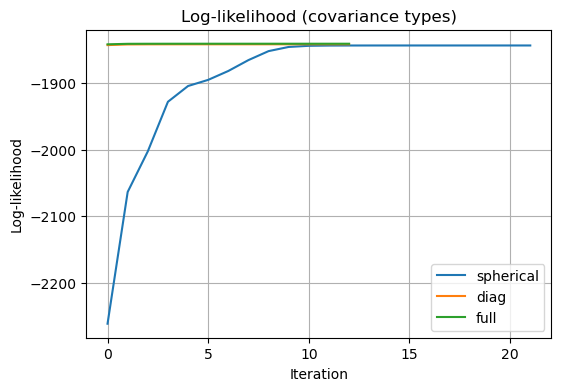

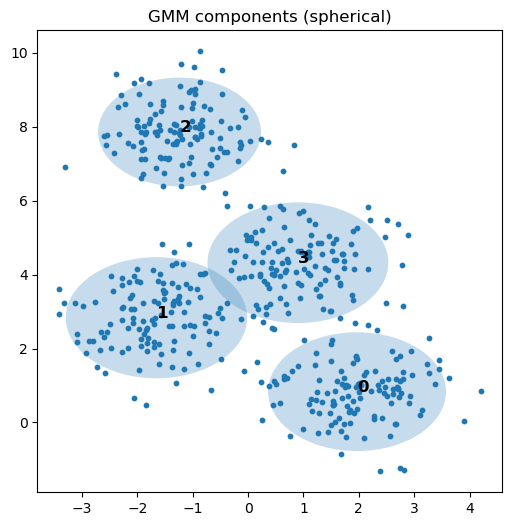

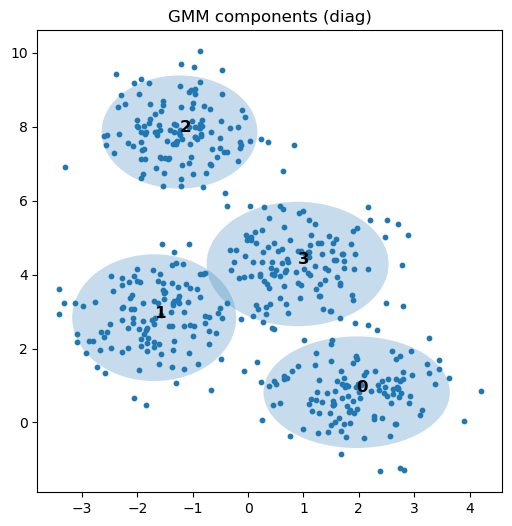

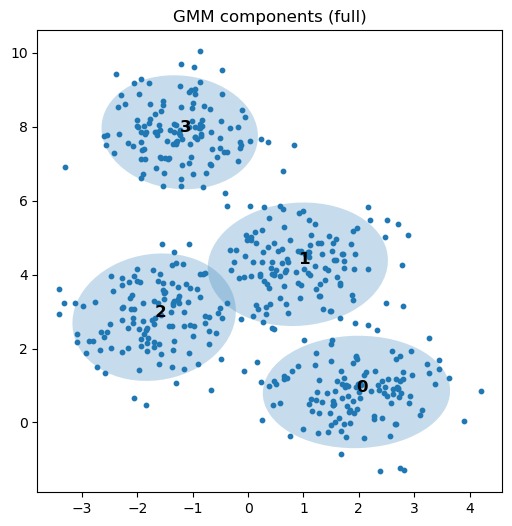

c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


Init: kmeans LL = -1840.9978829718839 random LL = -1840.9978595786508


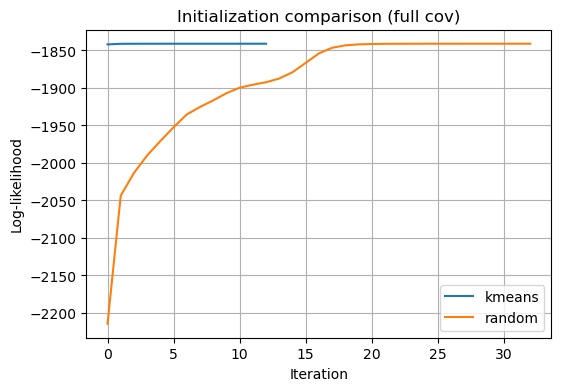

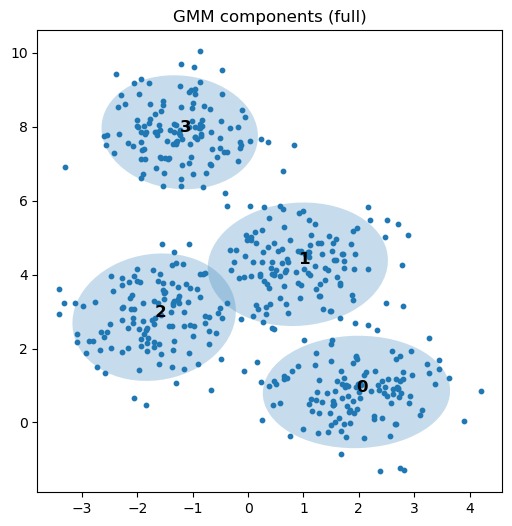

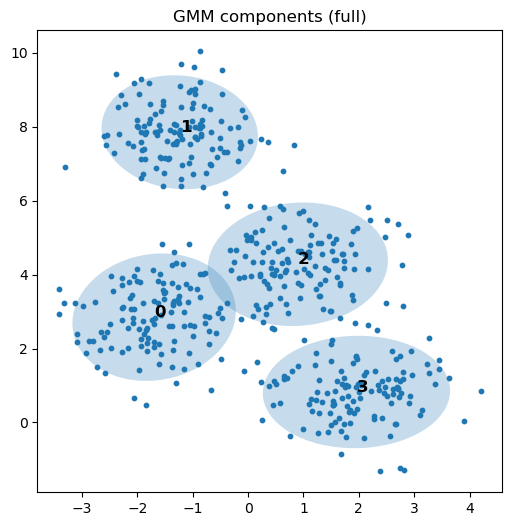

In [22]:
X, y_true = generate_data(n_samples=500, centers=4, cluster_std=0.8, random_state=0)

# quick compare different covariance types (single best init each)
k = 4
covs_to_try = ['spherical','diag','full']
models = []
for cov in covs_to_try:
    model = run_multiple_inits(X, k, cov_type=cov, n_init=2, init_method='kmeans', max_iter=100, tol=1e-4, var_floor=1e-6)
    print(f"{cov} -> final LL = {model['final_ll']:.2f}, iters = {model['n_iter']}")
    models.append(model)

plot_loglikelihood(models, labels=covs_to_try, title="Log-likelihood (covariance types)")
for model, cov in zip(models, covs_to_try):
    plot_gmm_ellipses(X, model, cov_type=cov)

# initialization comparison (kmeans vs random) for full covariance
model_km = run_multiple_inits(X, k, cov_type='full', n_init=2, init_method='kmeans', max_iter=100)
model_rand = run_multiple_inits(X, k, cov_type='full', n_init=2, init_method='random', max_iter=100)
print("Init: kmeans LL =", model_km['final_ll'], "random LL =", model_rand['final_ll'])
plot_loglikelihood([model_km, model_rand], labels=['kmeans','random'], title="Initialization comparison (full cov)")
plot_gmm_ellipses(X, model_km, cov_type='full')
plot_gmm_ellipses(X, model_rand, cov_type='full')

    

c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

K=1: LL=-2108.7, p=5.0, BIC=4248.5
K=2: LL=-1991.2, p=11.0, BIC=4050.7
K=3: LL=-1870.8, p=17.0, BIC=3847.3
K=4: LL=-1841.0, p=23.0, BIC=3824.9


c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


K=5: LL=-1836.3, p=29.0, BIC=3852.8
K=6: LL=-1829.1, p=35.0, BIC=3875.7


c:\Users\bhati\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


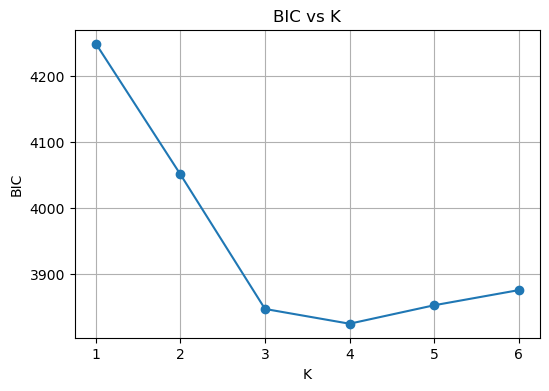

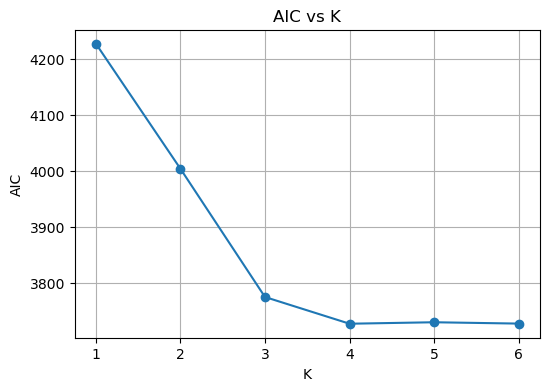

In [23]:
Ks = range(1,7)
bics, aics = [], []
for K in Ks:
    model = run_multiple_inits(X, K, cov_type='full', n_init=2, init_method='kmeans', max_iter=100)
    bic, aic, p = bic_aic(X, model)
    bics.append(bic); aics.append(aic)
    print(f"K={K}: LL={model['final_ll']:.1f}, p={p}, BIC={bic:.1f}")
plt.figure(figsize=(6,4)); plt.plot(list(Ks), bics, marker='o'); plt.xlabel('K'); plt.ylabel('BIC'); plt.title('BIC vs K'); plt.grid(True); plt.show()
plt.figure(figsize=(6,4)); plt.plot(list(Ks), aics, marker='o'); plt.xlabel('K'); plt.ylabel('AIC'); plt.title('AIC vs K'); plt.grid(True); plt.show()
